## Parameter estimation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.io
import os

from sklearn.neighbors import KernelDensity

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)# plt.style.use('fast')

plt.rcParams.update({
    'font.size': 14,
})

In [2]:
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/jags')
path_vba = os.path.join(path_out, 'vba')
path_jags_output = os.path.join(path_out, 'jags_output')

# Load posterior model probabilities
path_pmp = os.path.join(path_vba, 'pmp_HLM_sequential_split.mat')
mat = scipy.io.loadmat(path_pmp, squeeze_me=True)
pmp = mat['pmp']
modelnames = ['PICI', 'PICD', 'PDCI', 'PDCD']

# Load posterior samples for hierarchical model with PDCI submodel
path_h_pdci = os.path.join(path_jags_output, 'H_pdci.mat')
mat = scipy.io.loadmat(path_h_pdci, variable_names=['samples', 'nSamples', 'nChains'], squeeze_me=True)
samples = mat['samples']

n_samples, n_chains = mat['nSamples'], mat['nChains']
n_subjects, n_conditions = 32, 2
n_prederrsign = 2
sublabels = [f'm{sub:02}' for sub in range(2, n_subjects+2)]

# Load samples for relevant behavioral parameters
alpha_pdci = samples['alpha_pdci'].item()
beta_pdci = samples['beta_pdci'].item()
alpha_pdci = np.reshape(alpha_pdci, (n_chains * n_samples, n_subjects, n_prederrsign))
beta_pdci = np.reshape(beta_pdci, (n_chains * n_samples, n_subjects))

### Simple posterior examination



In [4]:
# Describe marginalized distribution of behavioral parameters
print(f'ME alpha+ = {np.mean(alpha_pdci[:, :, 0])}')
print(f'SD alpha+ = {np.std(alpha_pdci[:, :, 0])}')
print(f'ME alpha- = {np.mean(alpha_pdci[:, :, 1])}')
print(f'SD alpha- = {np.std(alpha_pdci[:, :, 1])}')
print(f'ME beta = {np.mean(beta_pdci)}')
print(f'SD beta = {np.std(beta_pdci)}\n')

# Calculate Bayes Factor alpha+ > alpha-
pdci_idx = (np.argmax(pmp, axis=0) == modelnames.index('PDCI'))
bf_plus_minus = (np.sum(alpha_pdci[:, :, 0] > alpha_pdci[:, :, 1]) 
              / np.sum(alpha_pdci[:, :, 1] > alpha_pdci[:, :, 0]))
bf_plus_minus_only_pdci = (np.sum(alpha_pdci[:, pdci_idx, 0] > alpha_pdci[:, pdci_idx, 1]) 
                        / np.sum(alpha_pdci[:, pdci_idx, 1] > alpha_pdci[:, pdci_idx, 0]))
print(f'BF(alpha+ > alpha-) = {bf_plus_minus}')
print(f'BF(alpha+ > alpha-; PDCI subjects) = {bf_plus_minus_only_pdci}')

ME alpha+ = 0.7366027877084681
SD alpha+ = 0.2749347221528298
ME alpha- = 0.41500499592687495
SD alpha- = 0.14884168292299235
ME beta = 0.1254196657501562
SD beta = 0.043113740888508764

BF(alpha+ > alpha-) = 4.782279121454966
BF(alpha+ > alpha-; PDCI subjects) = 37.89855665881871


### Point parameter estimation
Estimate learning rate values as point estimates of posterior probability distribution. First, MCMC samples are converted into continuous function using kernel density estimation (KDE) with Gaussian kernel. Then, argument maximizing estimated distribution is considered as point estimate of $\alpha$. Paramater `n_gridpoints` control the grid sparsity over parameter space (i.e. gridpoints for which KDE distribution is estimated). Smoothing of KDE distribution is adjusted by `kernel_width` parameter.

In [5]:
n_gridpoints = 1001
kernel_width = 0.01
gridpoints = np.linspace(0, 1, n_gridpoints)

alpha_pdci_mle = np.zeros((n_subjects, 2))
beta_pdci_mle = np.zeros((n_subjects, 1))

for sub in range(n_subjects):
    # Calculate parameters as maximum likelihood
    kde = KernelDensity(bandwidth=kernel_width, kernel='gaussian')
    
    # Learning rates
    for j in range(n_prederrsign):
        kde.fit(alpha_pdci[:, sub, j].flatten()[:, np.newaxis])
        alpha_pdci_mle[sub, j] = gridpoints[np.argmax(
            kde.score_samples(gridpoints[:, np.newaxis]))]
    
    # Precision
    kde.fit(beta_pdci[:, sub].reshape((n_samples * n_chains, 1)))
    beta_pdci_mle[sub] = gridpoints[np.argmax(
        kde.score_samples(gridpoints[:, np.newaxis]))]
    
# Save to file
np.save(os.path.join(path_out, 'parameter_estimates/alpha_pdci_mle_3digits'), 
        alpha_pdci_mle)
np.save(os.path.join(path_out, 'parameter_estimates/beta_pdci_mle_3digits'), 
        beta_pdci_mle)

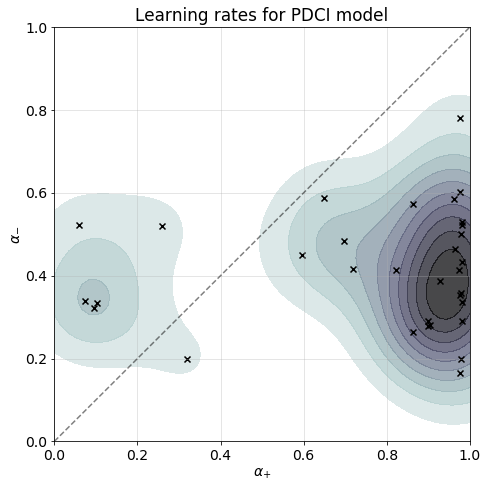

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(7, 7))

ax.plot([0, 1], [0, 1], 'k--', alpha=.5)
sns.kdeplot(
    alpha_pdci_mle[:, 0],
    alpha_pdci_mle[:, 1],
    cmap="bone_r", 
    shade=True, 
    shade_lowest=False, 
    ax=ax,
    alpha=.75,
    bw=.1
)
ax.scatter(
    alpha_pdci_mle[:, 0], 
    alpha_pdci_mle[:, 1],
    color='black', 
    marker='x'
)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(alpha=.4)
ax.set_title('Learning rates for PDCI model')
ax.set_xlabel(r'$\alpha_{+}$')
ax.set_ylabel(r'$\alpha_{-}$')

plt.tight_layout()